In [1]:
%cd ..

/home/ubuntu/OptiServe


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import datetime


from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.cost_calculator import CostCalculator
from src.modeling.function_performance_modeling import FunctionPerformanceModeling
from src.profiler.explorer import Explorer
from src.optimizer.parametric_function import ParamFunction

In [3]:
functions = [
    'resnet',
    'yolo',
    'f5',
    'bert'
]

resnet_variant = 'resnet-18'
yolo_variant = 'yolov10n'
bert_variant = 'distilbert-base-uncased'

region_name = 'us-east-1'

In [4]:
duration_per_memory = {
    'resnet': ParamFunction.load('modeled_functions/' + 'resnet_' + resnet_variant + '.mdl'),
    'yolo': ParamFunction.load('modeled_functions/' + 'yolo_' + yolo_variant + '.mdl'),
    'f5': ParamFunction.load('modeled_functions/' + 'f5' + '.mdl'),
    'bert': ParamFunction.load('modeled_functions/' + 'bert_' + bert_variant + '.mdl')
}

In [5]:
dfs = {'resnet': AWSFunctionLogs(
        boto_session=boto3.Session(region_name=region_name),
        function_name='resnet', docker_deploy=True,
    ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=5)).timestamp()),
        end_time=int(datetime.datetime.utcnow().timestamp()), model_name=resnet_variant),
    'yolo': AWSFunctionLogs(
        boto_session=boto3.Session(region_name=region_name),
        function_name='yolo', docker_deploy=True,
    ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=5)).timestamp()),
        end_time=int(datetime.datetime.utcnow().timestamp()), model_name=yolo_variant),
    'f5': AWSFunctionLogs(
        boto_session=boto3.Session(region_name=region_name),
        function_name='f5',
    ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=5)).timestamp()),
        end_time=int(datetime.datetime.utcnow().timestamp())),
    'bert': AWSFunctionLogs(
        boto_session=boto3.Session(region_name=region_name),
        function_name='bert', docker_deploy=True,
    ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=5)).timestamp()),
        end_time=int(datetime.datetime.utcnow().timestamp()), model_name=bert_variant),}

In [6]:
cost_calculator = CostCalculator()

In [7]:
legend_labels = {
    'resnet': "Image Classification (ResNet-18)",
    'yolo': "Object Detection (YOLOv10n)",
    'f5': "SHA512 Computation",
    'bert': "Sequence Classification (DistilBERT)"
}

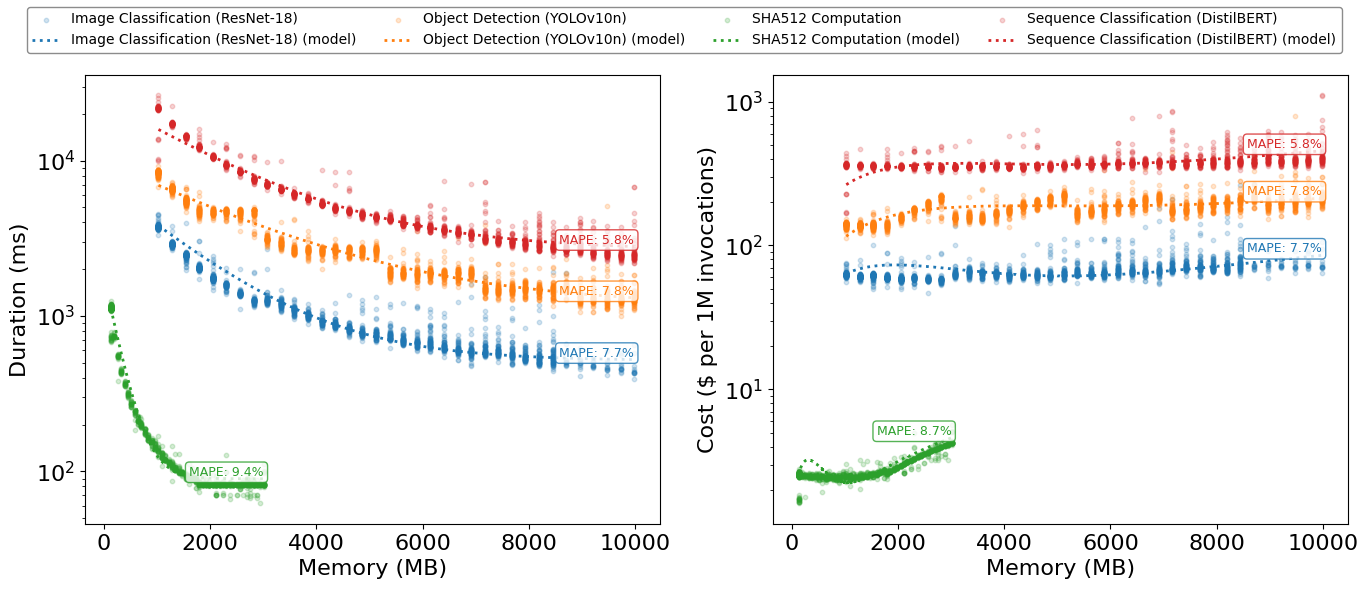

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Prepare raw logs
raw_logs = {}

for function in functions:
    df = dfs[function][dfs[function]['Init Duration'].isna()].copy()

    # Compute cost per invocation, scaled to 1M
    df['Cost'] = df.apply(
        lambda row: cost_calculator.calculate_cost(
            memory_mb=row['Memory Size'],
            duration_ms=row['Duration']
        ) * 1_000_000,
        axis=1
    )

    raw_logs[function] = df

# Step 2: Plot both figures side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.tab10.colors

for idx, (function, df) in enumerate(raw_logs.items()):
    color = colors[idx % len(colors)]

    # Execution time (left)
    axes[0].scatter(df['Memory Size'], df['Duration'], alpha=0.2, s=10, color=color, label=legend_labels[function])

    # Cost (right)
    axes[1].scatter(df['Memory Size'], df['Cost'], alpha=0.2, s=10, color=color, label=legend_labels[function])
    
    # Define memory range per function
    if function == 'f5':
        mem_range = np.arange(128, 3008 + 1, 1)
    else:
        mem_range = np.arange(1024, 9984 + 1, 1)

    # Get modeled durations
    predicted_durations = [duration_per_memory[function](mem) for mem in mem_range]

    # Plot modeled execution time
    axes[0].plot(
        mem_range,
        predicted_durations,
        color=color,
        linestyle='dotted',
        linewidth=2,
        label=f"{legend_labels[function]} (model)"
    )

    # Modeled cost based on predicted durations
    predicted_costs = [
        cost_calculator.calculate_cost(memory_mb=mem, duration_ms=dur) * 1_000_000
        for mem, dur in zip(mem_range, predicted_durations)
    ]

    # Plot modeled cost
    axes[1].plot(
        mem_range,
        predicted_costs,
        color=color,
        linestyle='dotted',
        linewidth=2,
        label=f"{legend_labels[function]} (model)"
    )

    # ----------------------------
    # Add MAPE box for Duration
    # ----------------------------
    median_durations = df.groupby('Memory Size')['Duration'].median()
    mems = median_durations.index.values
    true_durations = median_durations.values
    pred_durations = [duration_per_memory[function](m) for m in mems]
    mape_dur = mean_absolute_percentage_error(true_durations, pred_durations) * 100

    axes[0].text(
        x=mems[-1],
        y=pred_durations[-1],
        s=f"MAPE: {mape_dur:.1f}%",
        fontsize=9,
        color=color,
        ha='right',
        va='bottom',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white', alpha=0.8)
    )

    # ------------------------
    # Add MAPE box for Cost
    # ------------------------
    true_costs = df.groupby('Memory Size')['Cost'].median().values
    pred_costs = [
        cost_calculator.calculate_cost(memory_mb=m, duration_ms=duration_per_memory[function](m)) * 1_000_000
        for m in mems
    ]
    mape_cost = mean_absolute_percentage_error(true_costs, pred_costs) * 100

    axes[1].text(
        x=mems[-1],
        y=pred_costs[-1],
        s=f"MAPE: {mape_cost:.1f}%",
        fontsize=9,
        color=color,
        ha='right',
        va='bottom',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white', alpha=0.8)
    )

# Format left plot
axes[0].set_xlabel("Memory (MB)")
axes[0].set_ylabel("Duration (ms)")
axes[0].set_yscale("log")

# Format right plot
axes[1].set_xlabel("Memory (MB)")
axes[1].set_ylabel("Cost ($ per 1M invocations)")
axes[1].set_yscale("log")

# Shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=len(functions),
    fontsize=10,
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    edgecolor='gray',
    facecolor='white'
)

plt.rcParams.update({'font.size': 16})  # Set global default font size

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("function-modeling.pdf", format="pdf", bbox_inches="tight")
plt.show()
